In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from config import *
plt.rcParams['font.family'] = 'Arial'

### fig. 1a

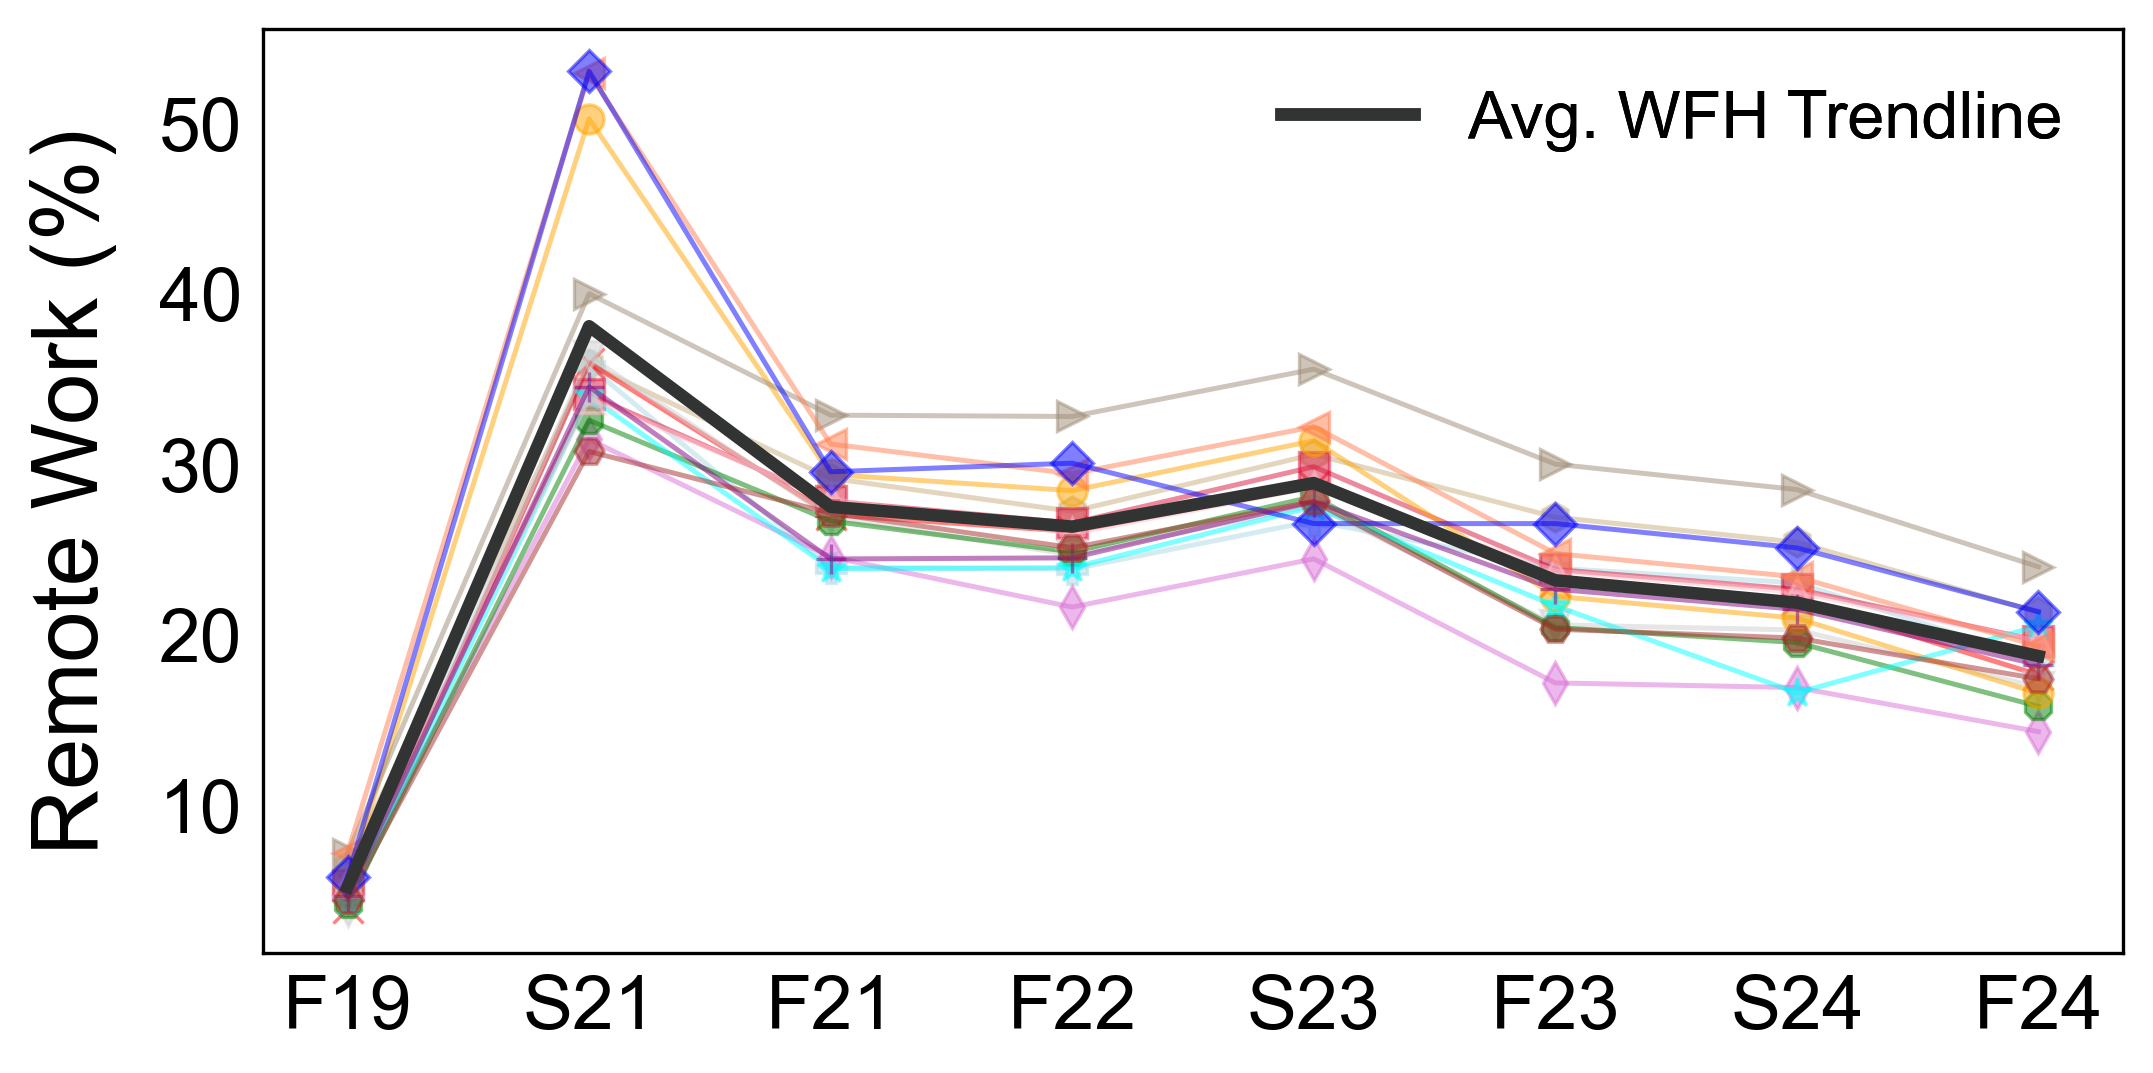

In [2]:
data = pd.read_csv('data/fig1/wfh_all.csv')

plt.figure(figsize=(8, 4), dpi=300)
season_vals = {season: [] for season in season_list}

for city in acr_list:
    if city in data['city_abbr'].values:
        city_data = data[data['city_abbr'] == city]
        if not city_data.empty:

            values = [city_data[season].values[0] if season in city_data.columns and not pd.isna(city_data[season].values[0]) else np.nan for season in season_list]
            values = np.array(values) * 100

            for i, season in enumerate(season_list):
                if not pd.isna(values[i]):
                    season_vals[season].append(values[i])
            
            # optional width cust
            lw = 1.2 if city in ['ny', 'bos', 'chi','phi', 'sf'] else 1.2
            a = 0.5 if city in ['ny', 'bos', 'chi','phi', 'sf'] else 0.5
            
            plt.plot(
                range(len(season_list)), 
                values, 
                marker=acr_marker.get(city),
                color=acr_color.get(city), 
                label=city,
                linewidth=lw,
                alpha=a,
                markeredgewidth=0.8,
                markersize=7
            )

# calc avg trendline
avg_values = [np.mean(season_vals[season]) if season_vals[season] else np.nan for season in season_list]

avg_line, = plt.plot(
    range(len(season_list)),
    avg_values,
    color='#323333',
    linewidth=3,
    label='Average'
)

# tick specs
plt.xticks(
    range(len(season_list)), 
    season_display,
    fontsize=18
)

plt.yticks(fontsize=18)

plt.tick_params(axis='x', which='major', pad=5)
plt.tick_params(axis='y', which='major', pad=5)
plt.tick_params(axis='both', direction='in', length=0, width=0)
ax = plt.gca() # ticks on all sides
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.ylabel("Remote Work (%)", fontsize=22, labelpad=10)

# wfh legend
wfh_legend_elements = [
    plt.Line2D([0], [0], color='#323333', linewidth=3.0, label=r'Avg. WFH Trendline'),
]

wfh_legend = plt.legend(handles=wfh_legend_elements, 
           loc='upper right',
           frameon=False,
           fontsize=16)

ax.add_artist(wfh_legend)

### fig. 1b

In [3]:
def fade_color(hex_color, alpha=0.15):
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

def load_data(naics_path, wfh_path):
    # load naics count
    df = pd.read_csv(naics_path)
    df = df[df['season'] == 'fa23']
    if 'city' in df.columns:
        df.rename(columns={'city': 'abbr'}, inplace=True)
    df['full_city'] = df['abbr'].map(acr_csa_dict)
    
    # load wfh pct
    wfh_df = pd.read_csv(wfh_path)
    
    # map wfh to naics sector
    wfh_dict = {}
    for _, row in wfh_df.iterrows():
        remote_col = row['naics']
        naics_code = 'total_' + remote_col.replace('pct_', '').replace('_remote', '')
        if naics_code in naics_sector:
            wfh_dict[naics_code] = float(row['pct_wfh'])
    
    return df.groupby('full_city')[naics_sector].sum().reset_index(), wfh_dict

def order_naics(agg_df):
        
    # extract raw sums for each sector
    raw_sums = {}
    for cat in naics_sector:
        cat_sum = float(agg_df[cat].sum())
        raw_sums[cat] = cat_sum
    
    # calc total
    total_jobs = float(sum(raw_sums.values()))
    
    # calc pct
    job_percentages = {}
    for cat in naics_sector:
        percentage = (raw_sums[cat] / total_jobs) * 100
        job_percentages[cat] = percentage
    
    return sorted(naics_sector, key=lambda x: job_percentages[x], reverse=True)

def plot_sankey(agg_df, wfh_dict):

    agg_df = agg_df[agg_df['full_city'].isin(csa_order)].copy()
    ordered_rows = [agg_df[agg_df['full_city'] == c] for c in csa_order if c in agg_df['full_city'].values]
    agg_df = pd.concat(ordered_rows).reset_index(drop=True)
    
    sorted_naics = order_naics(agg_df)
    
    # prep nodes
    city_nodes = [csa_city_dict[c] for c in csa_order if c in agg_df['full_city'].values]
    naics_nodes = [naics_dict[cat] for cat in sorted_naics]
    work_nodes = ['In-Person', 'WFH']
    
    node_labels = city_nodes + naics_nodes + work_nodes
    
    n_cities = len(city_nodes)
    n_naics = len(naics_nodes)
    
    # draw links
    city_idx = {c: i for i, c in enumerate(csa_order) if c in agg_df['full_city'].values}
    cat_color = {cat: naics_color[i % len(naics_color)] for i, cat in enumerate(sorted_naics)}
    
    source, target, value, colors = [], [], [], []
    
    # city-->naics
    for _, row in agg_df.iterrows():
        city_idx_val = city_idx[row['full_city']]
        top5 = sorted([cat for cat in sorted_naics if row[cat] > 0], 
                      key=lambda cat: row[cat], reverse=True)[:5]
        
        for cat in sorted_naics:
            flow = row[cat]
            if flow > 0:
                source.append(city_idx_val)
                target.append(n_cities + sorted_naics.index(cat))
                value.append(flow)
                colors.append(cat_color[cat] if cat in top5 else fade_color(cat_color[cat]))
    
    # naics-->work
    in_person_idx = n_cities + n_naics
    wfh_idx = n_cities + n_naics + 1
    
    # proc naics sectors
    for naics_code in sorted_naics:
        naics_idx = n_cities + sorted_naics.index(naics_code)
        total_flow = agg_df[naics_code].sum()
        
        if total_flow > 0:
            wfh_pct = wfh_dict.get(naics_code, 0.0)
            
            # wfh flow
            wfh_flow = total_flow * wfh_pct
            if wfh_flow > 0:
                source.append(naics_idx)
                target.append(wfh_idx)
                value.append(wfh_flow)
                colors.append(cat_color[naics_code])
            
            # in-person flow
            in_person_flow = total_flow * (1 - wfh_pct)
            if in_person_flow > 0:
                source.append(naics_idx)
                target.append(in_person_idx)
                value.append(in_person_flow)
                colors.append(fade_color(cat_color[naics_code], 0.5))
    
    # node specs
    node_colors = []
    
    # panel 1: city
    for label in city_nodes:
        full_key = [k for k, v in csa_city_dict.items() if v == label][0]
        node_colors.append(csa_color.get(full_key, '#cccccc'))
    # panel 2: sector
    for cat in sorted_naics:
        node_colors.append(cat_color[cat])
    # panel 3: work
    node_colors.extend(['darkgrey', '#39FF14'])  # in-person, wfh
    
    # node positions
    city_x, naics_x, work_x = 0.01, 0.4, 0.99
    city_y = np.linspace(0.02, 0.98, n_cities)
    naics_y = np.linspace(0.02, 0.98, n_naics)
    work_y = np.linspace(0.3, 0.7, 2)
    
    node_x = [city_x]*n_cities + [naics_x]*n_naics + [work_x]*2
    node_y = list(city_y) + list(naics_y) + list(work_y)
    
    # plot sankey
    sankey = go.Sankey(
        arrangement='fixed',
        node=dict(
            pad=40,
            thickness=20,
            line=dict(color='lightgrey', width=0),
            label=node_labels,
            color=node_colors,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=colors
        )
    )
    
    fig = go.Figure(data=[sankey])
    fig.update_layout(
        font=dict(family='sans-serif', size=26),
        width=850,
        height=1000,
        margin=dict(l=0.01, r=0.01, t=0.01, b=0.01)
    )
    return fig

# run
naics_path = 'data/fig1/naics_all.csv'
wfh_path = 'data/fig1/naics-wfh_fa23.csv'
    
agg_df, wfh_dict = load_data(naics_path, wfh_path)
fig = plot_sankey(agg_df, wfh_dict)
fig.show()

### fig. 1c

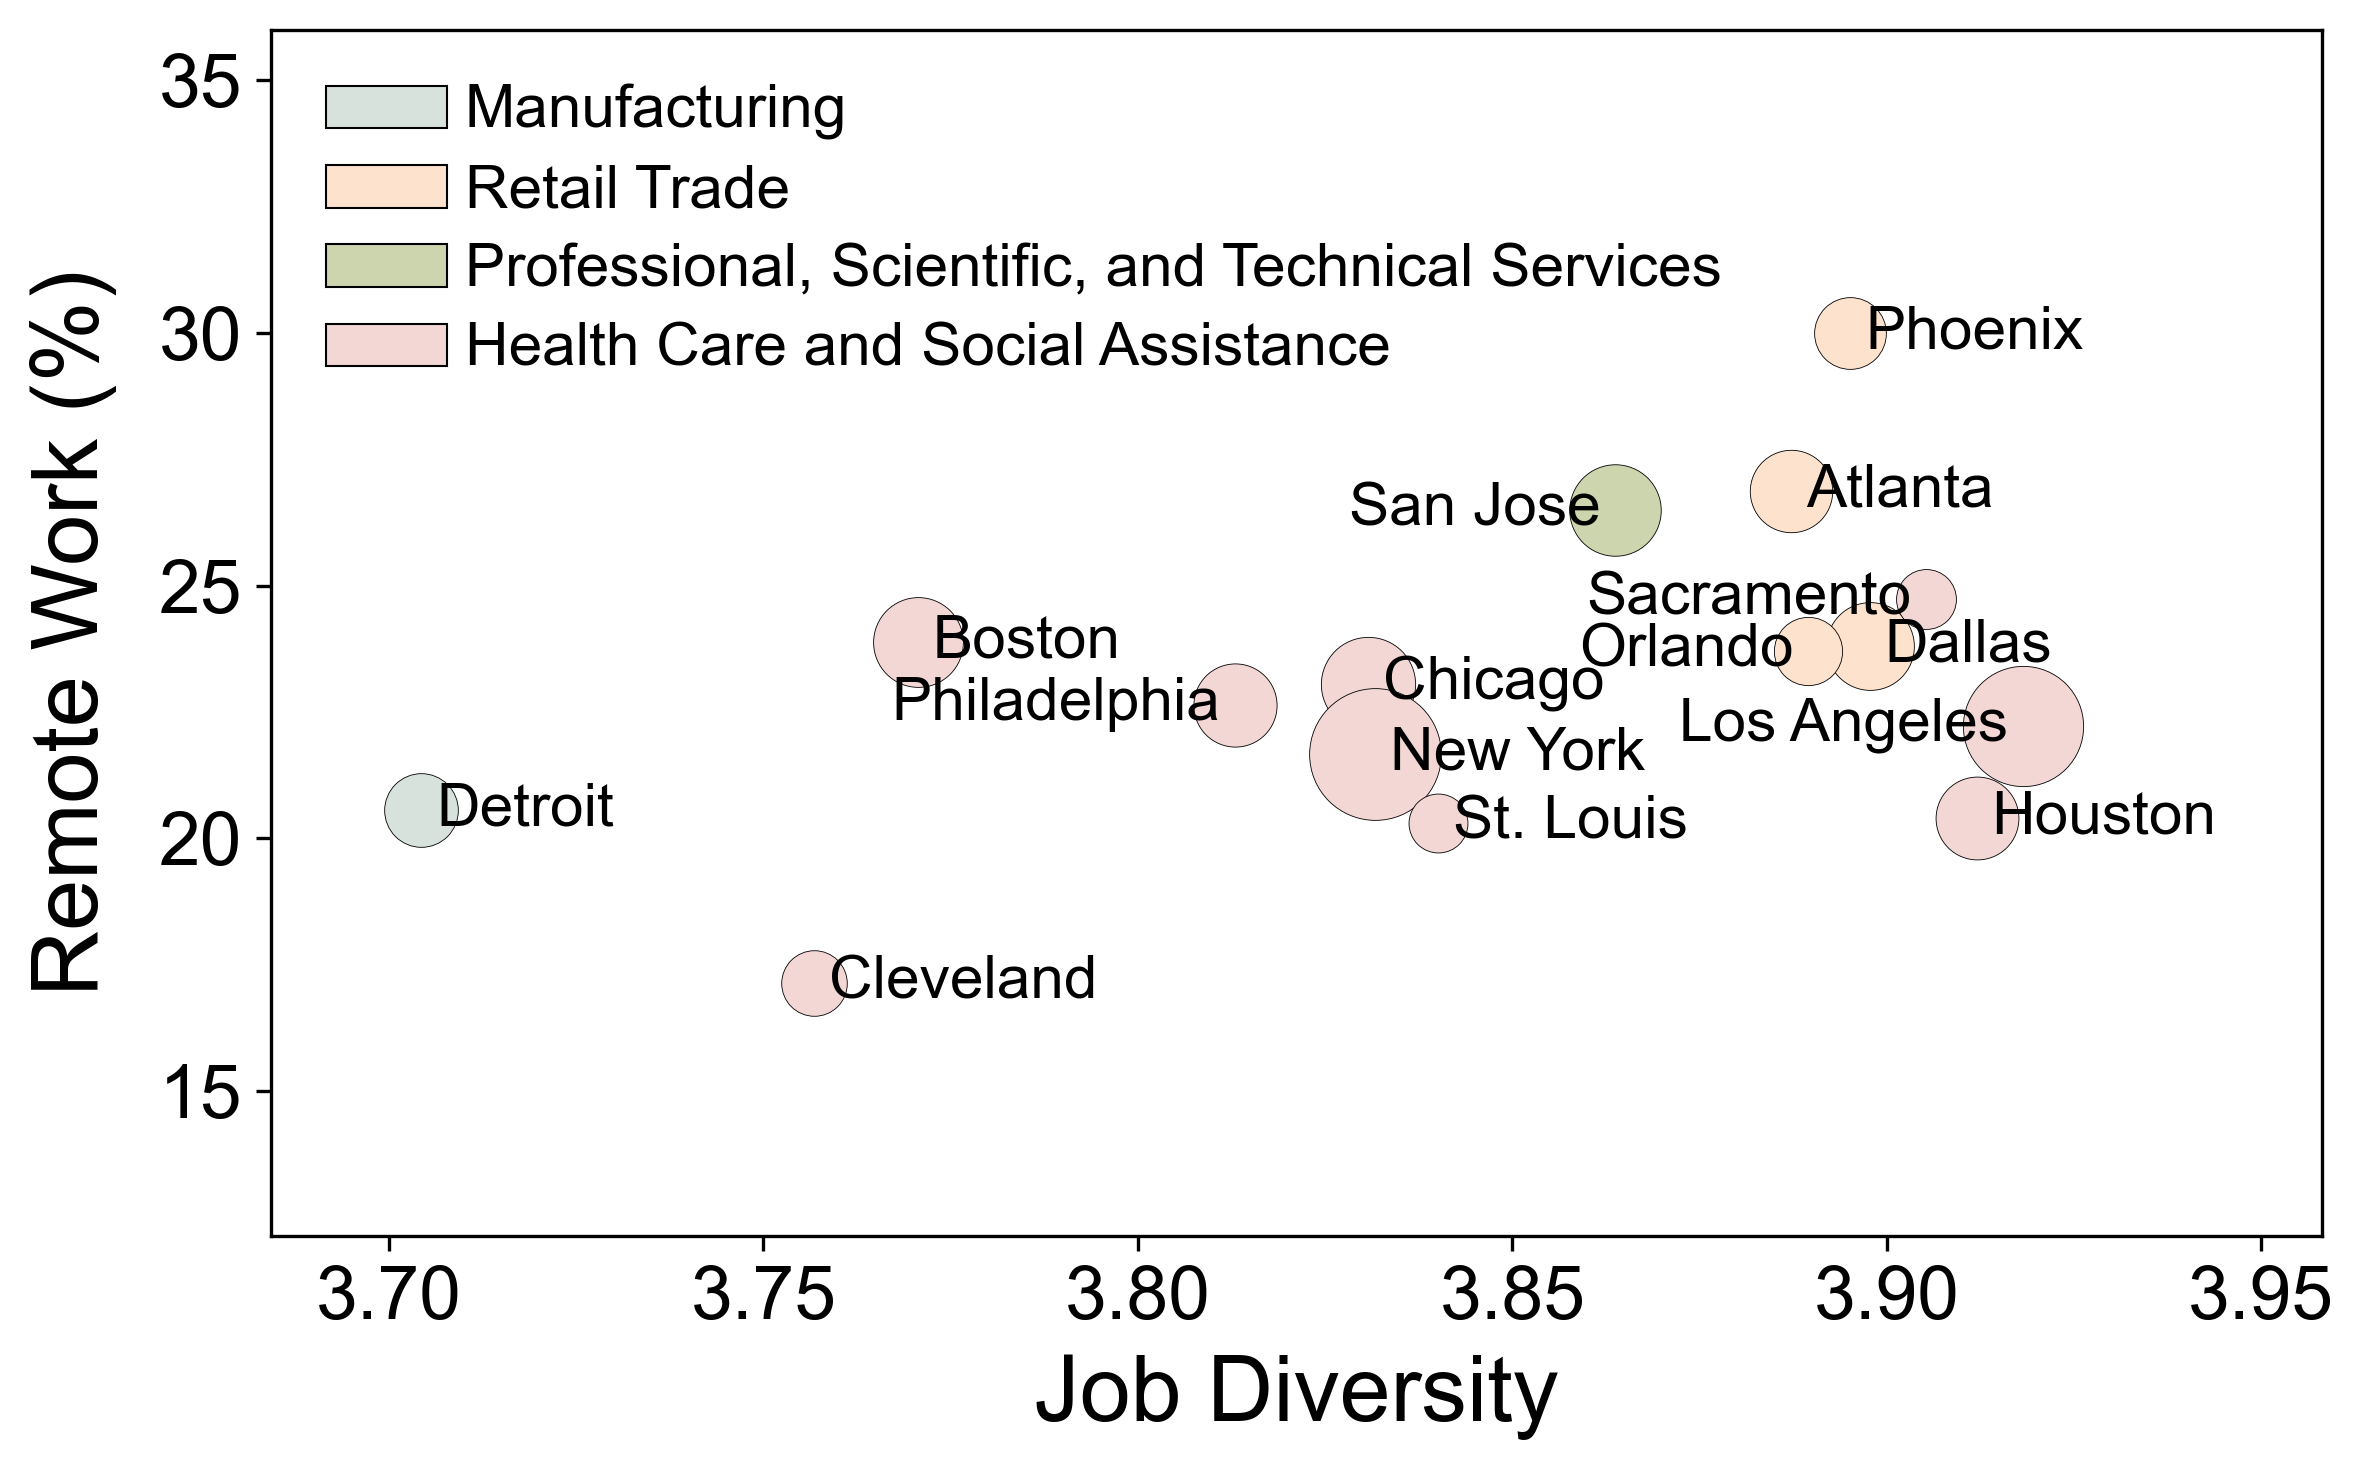

In [4]:
def compute_city(naics_df, wfh_df):
    naics_df['full_city'] = naics_df['city'].map(acr_csa_dict)
    
    colors, labels, dominant_naics = [], [], set()
    
    for city, city_df in naics_df.groupby('full_city'):
        city_total = city_df[naics_sector].sum()
        max_cat = city_total.idxmax()
        
        colors.append(naics_color_dict[max_cat])
        labels.append(csa_acr_map[city])
        dominant_naics.add(max_cat)
    
    city_naics_color = pd.DataFrame({
        'city_abbr': labels,
        'color': colors
    })
    
    return wfh_df.merge(city_naics_color, on='city_abbr'), sorted(dominant_naics)

def plot_diversity_wfh(df, dominant_naics, show_labels=True):
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    ax.set_xlabel('Job Diversity', fontsize=22, labelpad=5)
    ax.set_ylabel('Remote Work (%)', fontsize=22, labelpad=10)
    
    min_x, max_x = df['job_diversity'].min(), df['job_diversity'].max()
    min_y, max_y = df['pct_wfh'].min() * 100, df['pct_wfh'].max() * 100
    ax.set_xlim(min_x - 0.02, max_x + 0.04)
    ax.set_ylim(min_y - 5, max_y + 6)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    sizes_scaled = np.interp(df['total_jobs'], (df['total_jobs'].min(), df['total_jobs'].max()), (200, 1000))
    
    # plot scatter
    for i, row in df.iterrows():
        ax.scatter(row['job_diversity'], row['pct_wfh'] * 100, color=row['color'], 
                  s=sizes_scaled[i], edgecolor='black', linewidth=0.2, zorder=3)
    
    # add labels
    if show_labels:
        for i, row in df.iterrows():
            city_name = acr_city_dict[row['city_abbr']]
            if row['city_abbr'] in ['orl', 'la', 'phi', 'sac', 'sf']:
                ax.text(row['job_diversity'] - 0.002, row['pct_wfh'] * 100, city_name, 
                       fontsize=14.5, va='center', ha='right', zorder=10)
            else:
                ax.text(row['job_diversity'] + 0.002, row['pct_wfh'] * 100, city_name, 
                       fontsize=14.5, va='center', ha='left', zorder=10)
    
    # add naics legend
    legend_elements = [mpatches.Patch(facecolor=naics_color_dict[code], edgecolor='black', 
                                      linewidth=0.5, label=naics_dict[code]) 
                      for code in dominant_naics]
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=14.5,
             handletextpad=0.3, labelspacing=0.4)
    
    plt.tight_layout()
    return fig

naics_path = 'data/fig1/naics_all.csv'
wfh_path = 'data/fig1/wfh-diversity_fa23.csv'

naics_df = pd.read_csv(naics_path)
naics_df = naics_df[naics_df['season'] == 'fa23']
wfh_df = pd.read_csv(wfh_path)
merged_df, dominant_naics = compute_city(naics_df, wfh_df)
fig = plot_diversity_wfh(merged_df, dominant_naics, show_labels=True)

### fig. 1d

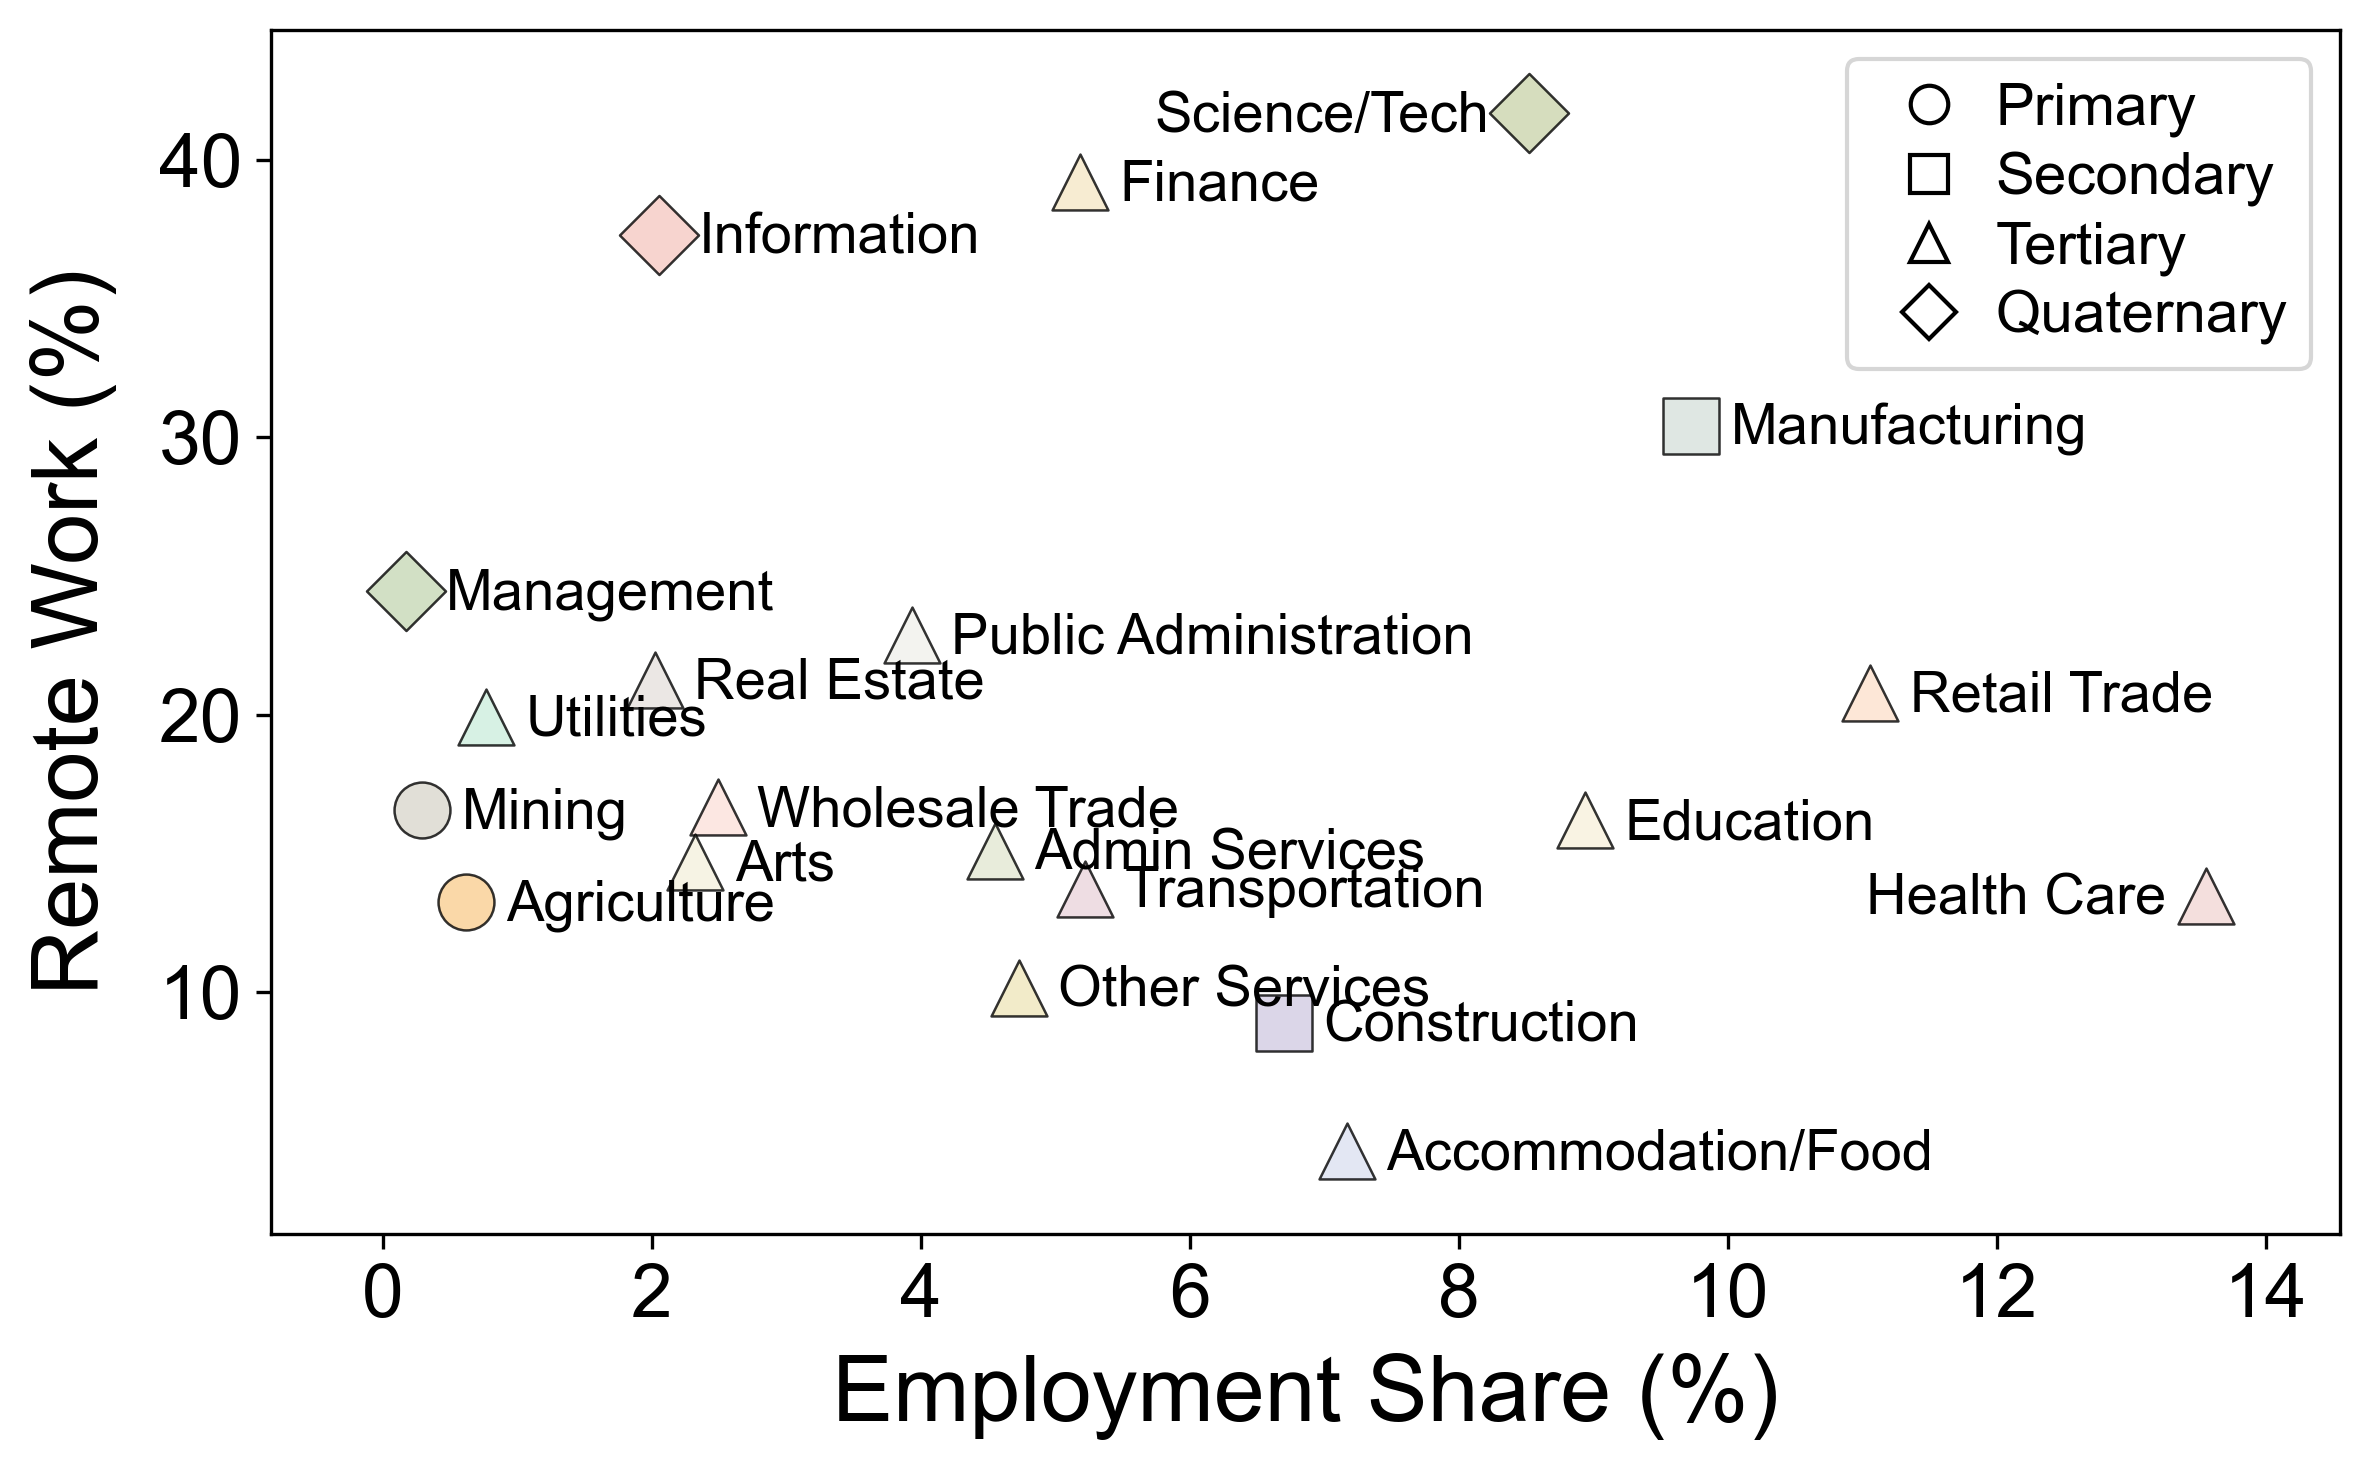

In [5]:
def plot_scatter(df):
    df['naics_name_mapped'] = df['naics_name'].map(name_mapping).fillna(df['naics_name'])
    
    x = df['avg_pct'].values * 100
    y = df['avg'].values * 100
    industry_names = df['naics_name_mapped'].values
    
    markers = [sector_markers[sector_class[industry]] for industry in industry_names]
    colors = [naics2colors[industry] for industry in industry_names]
    
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    
    for i in range(len(x)):
        ax.scatter([x[i]], [y[i]], s=180, alpha=0.8,
                   marker=markers[i], facecolor=colors[i], 
                   edgecolor='black', lw=0.6, zorder=2)
        
        if abbr_mapping[industry_names[i]] in ['Health Care', 'Science/Tech']:
            ax.annotate(abbr_mapping[industry_names[i]], (x[i], y[i]), 
                        xytext=(-9.5, -4.5), textcoords='offset points',
                        fontsize=13.5, zorder=3, ha='right')
        else:
            ax.annotate(abbr_mapping[industry_names[i]], (x[i], y[i]), 
                        xytext=(9.5, -4.5), textcoords='offset points',
                        fontsize=13.5, zorder=3)
    
    ax.set_xlim(x.min() - 1, x.max() + 1)
    ax.set_ylim(y.min() - 3, y.max() + 3)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('Employment Share (%)', fontsize=22, labelpad=5)
    ax.set_ylabel('Remote Work (%)', fontsize=22, labelpad=10)
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markersize=9, 
               label='Primary', markeredgecolor='black'),
        Line2D([0], [0], marker='s', color='w', markersize=9, 
               label='Secondary', markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', markersize=9, 
               label='Tertiary', markeredgecolor='black'),
        Line2D([0], [0], marker='D', color='w', markersize=9, 
               label='Quaternary', markeredgecolor='black')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=14, frameon=True, handletextpad=0.15, labelspacing=0.25)
    plt.tight_layout()
    
    return fig

# run
data_path = 'data/fig1/wfh_fa23.csv'
df = pd.read_csv(data_path)
fig = plot_scatter(df)